In [1]:
! pip install pyro-ppl

In [2]:
import random
import string
import os
import itertools
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.utils import probs_to_logits
from utils import *

In [3]:
pcfg = {
  "name": "astronomers",
  "terminals": ["astronomers", "ears", "saw", "stars", "telescopes", "with"],
  "non_terminals": ["S", "NP", "VP", "PP", "P", "V"],
  "productions": {
    "S": [["NP", "VP"]],
    "NP": [["NP", "PP"], ["astronomers"], ["ears"], ["saw"], ["stars"], ["telescopes"]],
    "VP": [["V", "NP"], ["VP", "PP"]],
    "PP": [["P", "NP"]],
    "P": [["with"]],
    "V": [["saw"]]
  },
  "start_symbol": "S",
}
true_production_probs = {
    "S": [1.0],
    "NP": [0.4, 0.1, 0.18, 0.04, 0.18, 0.1],
    "VP": [0.7, 0.3],
    "PP": [1.0],
    "P": [1.0],
    "V": [1.0]
}
max_depth_parse_tree = 20
slient = True
terminate_symbol = "__"

In [4]:
prior_production_logits = {
    k: torch.randn((len(v),)) 
    for k, v in pcfg['productions'].items()
}
ground_truth_production_logits = {
    k: probs_to_logits(torch.tensor(true_production_probs[k]))
    for k, v in pcfg['productions'].items()
}
if not slient:
    print(prior_production_logits)
    print(ground_truth_production_logits)

In [5]:
def generate_sentences(production_logits):
    
    def sample_parse_tree(symbol = None, depth = 0, suffix = "root"):
        if symbol is None:
            symbol = pcfg['start_symbol']
        if symbol in pcfg['terminals']:
            return symbol
        elif depth > max_depth_parse_tree:
            return terminate_symbol
        else:
            if not slient:
                print("symbol=>", symbol, production_logits[symbol])
            distribution = dist.Categorical(logits=production_logits[symbol])
            production_index = distribution.sample().detach()
            production = pcfg['productions'][symbol][production_index]
            return [symbol] + \
                [sample_parse_tree(s, depth=depth + 1, suffix = f"{suffix}_d{depth}/{i}") for i, s in enumerate(production)]
    tree = sample_parse_tree()
    if not slient:
        print("tree =>", tree)
    sentence = get_leaves(tree, max_depth_parse_tree, terminate_symbol)
    # how do we state observations, levenshtein distance?
    # may also use factor on levenshtein distance between gen and obs sentences and observe with 0

    # pad and normal distribution but very low sigma
    gen_sentence = pad_sentence(sentence_to_one_hots(sentence, pcfg["terminals"]), len(sentence))
    return sentence, gen_sentence, tree
if not slient:
    print(generate_sentences(prior_production_logits))
    print(generate_sentences(ground_truth_production_logits))

In [6]:
import model as model
import guide_obs_v4 as guide

In [7]:
if not slient:
    model.model(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [8]:
# obs_embedder_gru = nn.GRU(
#     input_size=6,
#     hidden_size=100,
#     num_layers=1
# )
obs_embedder_gru = convertion_embedding

def wrapped_guide(start_symbol='S', terminals=["astronomers", "ears", "saw", "stars", "telescopes", "with"], 
                  max_depth_parse_tree=20, terminate_symbol='__', observations={'obs': 0}):
    #print("print(observations['obs'].shape)", observations['obs'].shape)
    pyro.module('obs_embedder_gru', obs_embedder_gru)
    embedded_obs, _ = obs_embedder_gru(observations['obs'].unsqueeze(1))
    return guide.model(start_symbol, terminals, max_depth_parse_tree, terminate_symbol, {'obs' : embedded_obs[-1][0]})
if not slient:
    wrapped_guide(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [9]:
import tqdm
import matplotlib.pyplot as plt

In [10]:
pyro.clear_param_store()
smoke_test = False
n_steps = 10 if smoke_test else 20000
interval = 1 if smoke_test else 50
num_inference_samples = 2 if smoke_test else 10
optimiser = optim.Adam({"lr": 0.0005})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=num_inference_samples)
avg_l = 0
loss_trace = []
steps = []

In [11]:
def print_weights(name, model):
    print("@params in", name)
    for param in model.parameters():
        print(param)
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [12]:
def draw_from_model(n=1000, ground_truth=True):
    logits = production_logits if not ground_truth else ground_truth_production_logits
    sample_sentences = [generate_sentences(logits) for _ in range(n)]
    return sample_sentences
sample_sentences = draw_from_model(n=n_steps)
if not slient:
    sample_sentences[0]

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_merge_lhs)
n2 = count_parameters(guide._nn_model_sample_parse_tree_model_symbol)
n3 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n4 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n5 = count_parameters(guide._nn_tree)
n6 = count_parameters(obs_embedder_gru) # convertion_embedding
print(n1, n2, n3, n4, n5, n6, "total:", n1+n2+n3+n4+n5+n6)

36220 25660 42498 43014 20200 32400 total: 199992


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_obs_v4.py:190: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_VP_params,
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_obs_v4.py:180: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_NP_params,
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [3:10:07<00:00,  1.75it/s]


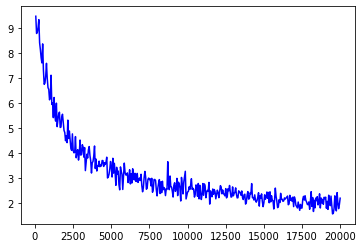

In [14]:
for step in tqdm.trange(n_steps):
    obs = sample_sentences[step]
    loss = csis.step(observations={"obs" : obs[1]})
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_trace.append(avg_l / interval)
        avg_l = 0

plt.plot(steps, loss_trace, "-b")
plt.show()

In [15]:
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [16]:
def drop_paddings(sentence_tensor):
    has_values = sentence_tensor.abs().sum(dim=-1).bool()
    return sentence_tensor[has_values]
def one_hot_sentence_to_list(sentence_tensor, terminals):
    sentence_np = sentence_tensor.cpu().detach().numpy()
    sentence_indices = np.argmax(sentence_np, axis=1)
    return [terminals[i] for i in sentence_indices]

In [17]:
def test(sentences, n=1):
    num_correct_n = 0
    num_correct_all = 0
    levenshtein_distances = {}
    for i in tqdm.trange(len(sentences)):
        obs = sentences[i]
        posterior = csis.run(observations={"obs" : obs[1]})
        marginal_ret = pyro.infer.EmpiricalMarginal(posterior)
        
        for i_sample in range(n):
            
            with torch.no_grad():
                _ret = marginal_ret()

            _ret = drop_paddings(_ret)
            num_correct_n += (torch.sum(obs[1]) == torch.sum(_ret))
            num_correct_all += torch.equal(obs[1], _ret)
            lev_dis = get_levenshtein_distance(one_hot_sentence_to_list(_ret, pcfg["terminals"]), 
                                               one_hot_sentence_to_list(obs[1], pcfg["terminals"]),
                                               pcfg["terminals"])
            if lev_dis in levenshtein_distances:
                levenshtein_distances[lev_dis] += 1
            else:
                levenshtein_distances[lev_dis] = 1
    
    avg_dis = 0  
    
    for k, v in levenshtein_distances.items():
        avg_dis += k * v

    return int(num_correct_n)  / len(sentences), int(num_correct_all) / len(sentences), levenshtein_distances, avg_dis / (len(sentences) * n)

example = ["astronomers", "saw", "stars", "with", "telescopes"]
example_sentence = sentence_to_one_hots(example, pcfg["terminals"])
print("example, n=1000", test([[None, example_sentence]], n=1000))
print("examples, 1000", test([[None, example_sentence]] * 1000))
print("train", test(sample_sentences[:1000]))
test_sentences = draw_from_model(n=1000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


example, n=1000 (1000.0, 1000.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:10<00:00,  4.00it/s]


examples, 1000 (1.0, 1.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:40<00:00,  1.56it/s]


train (0.825, 0.622, {0: 622, 2: 58, 3: 46, 13: 9, 8: 14, 7: 21, 1: 27, 10: 16, 9: 12, 14: 12, 11: 14, 6: 23, 4: 41, 5: 25, 12: 14, 16: 3, 17: 7, 33: 3, 36: 2, 19: 4, 23: 3, 15: 3, 30: 2, 40: 1, 107: 1, 44: 1, 20: 1, 21: 4, 25: 2, 24: 3, 22: 1, 32: 1, 18: 2, 31: 1, 27: 1}, 2.995)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:19<00:00,  1.62it/s]

test (0.812, 0.642, {13: 7, 0: 642, 3: 37, 14: 9, 19: 2, 1: 22, 8: 18, 2: 52, 9: 16, 11: 12, 5: 23, 6: 24, 22: 5, 7: 32, 16: 5, 31: 2, 12: 9, 25: 1, 18: 6, 4: 23, 10: 9, 35: 2, 30: 2, 33: 3, 15: 6, 27: 2, 23: 3, 21: 10, 20: 3, 43: 1, 24: 3, 37: 1, 26: 1, 32: 1, 41: 1, 40: 2, 48: 1, 64: 1, 28: 1}, 3.253)


In [18]:
test_sentences = draw_from_model(n=10000)
print("test", test(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:27:55<00:00,  1.90it/s]

test (0.8273, 0.6549, {7: 198, 0: 6549, 10: 124, 1: 255, 4: 303, 16: 76, 18: 49, 9: 160, 2: 485, 5: 235, 8: 175, 6: 195, 13: 86, 14: 85, 34: 7, 3: 327, 12: 92, 24: 24, 20: 39, 17: 50, 19: 36, 11: 115, 15: 62, 37: 4, 52: 2, 35: 7, 26: 17, 22: 29, 42: 4, 21: 28, 28: 14, 30: 14, 25: 26, 60: 2, 23: 22, 83: 2, 39: 4, 36: 8, 31: 12, 29: 11, 56: 2, 64: 1, 27: 10, 41: 4, 46: 2, 32: 9, 49: 4, 40: 2, 45: 5, 43: 3, 59: 2, 48: 1, 33: 4, 72: 1, 71: 1, 51: 1, 65: 1, 50: 1, 58: 1, 53: 1, 47: 2, 57: 1, 55: 1, 44: 2, 63: 1, 38: 3, 66: 1}, 3.0659)


In [19]:
print(loss_trace)

[9.466229802966119, 8.776588122844696, 8.822184760570526, 9.016863913834095, 9.330315189957618, 8.402672938108445, 8.136817807853221, 7.804259885549545, 7.599291098713874, 8.359529400467872, 7.307446800470352, 6.741125684902072, 6.791490248963237, 7.074065375961363, 7.582813684120774, 6.982546363286674, 6.61000138554722, 6.541408116910606, 6.1214053742960095, 6.2040701038017865, 7.106284867785871, 5.938256813092157, 6.006433863313869, 5.409087161170318, 6.215466373413801, 5.495813310956582, 5.269567918535322, 5.988517638067715, 5.048069678433239, 5.317805373816518, 5.546864723195322, 5.628139763916843, 5.0148825592501085, 5.031288433249574, 5.434540779865347, 5.544849635170539, 5.197942150554154, 4.897674744065153, 4.812014456739998, 4.484604129356448, 4.686619268483482, 4.407573060248105, 5.309312606648891, 4.574954965091893, 4.874159003773238, 4.506256383032888, 4.17375805735588, 4.099362745958206, 4.759082276257686, 4.096285971672769, 4.002480455974656, 4.0166279564716385, 4.6499423

In [20]:
print(min(loss_trace), loss_trace.index(min(loss_trace)))

1.5558350885419272 389
